In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def display_text_img(img,cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)

In [4]:
tire_img_1_BGR = cv2.imread('tire_images/img_4_con.jpg')
image_copy_orin = tire_img_1_BGR.copy()
gray = cv2.cvtColor(image_copy_orin, cv2.COLOR_BGR2GRAY)
image_copy_orin_gray = gray.copy()
ret,binary = cv2.threshold(gray, 90, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
#binarycv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15,-2) 
V = cv2.Sobel(binary, cv2.CV_8U, dx=1, dy=0)
H = cv2.Sobel(binary, cv2.CV_8U, dx=0, dy=1)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (14,14))
V = cv2.morphologyEx(V, cv2.MORPH_DILATE, kernel, iterations = 3)
H = cv2.morphologyEx(H, cv2.MORPH_DILATE, kernel, iterations = 3)

rows,cols = image_copy_orin.shape[:2]

mask_hor = np.zeros(image_copy_orin.shape[:2], dtype=np.uint8)
mask_ver = np.zeros(image_copy_orin.shape[:2], dtype=np.uint8)

contours = cv2.findContours(V, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[1]
for cnt in contours:
    (x,y,w,h) = cv2.boundingRect(cnt)
    cv2.drawContours(mask_ver, [cnt], -1, 255,-1)
    
contours = cv2.findContours(H, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[1]
for cnt in contours:
    (x,y,w,h) = cv2.boundingRect(cnt)
    cv2.drawContours(mask_hor, [cnt], -1, 255,-1)

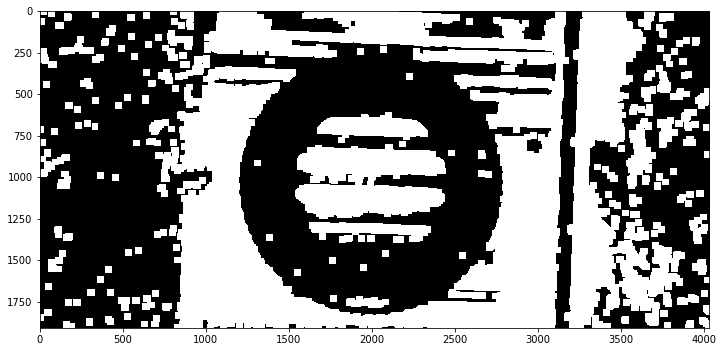

In [5]:
display_text_img(mask_hor)

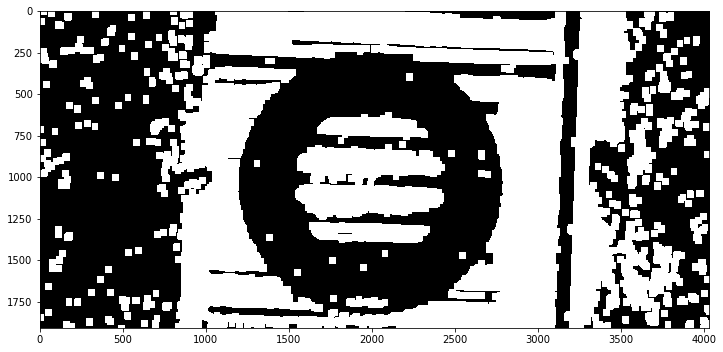

In [6]:
display_text_img(mask_ver)

# isolation techniques

In [9]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12,12))
erosion_ver = cv2.morphologyEx(tire_img_1_BGR, cv2.MORPH_DILATE, kernel, iterations = 3)
erosion_hor = cv2.morphologyEx(tire_img_1_BGR, cv2.MORPH_DILATE, kernel, iterations = 3)

#kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12,12))
#erosion_ver = cv2.morphologyEx(tire_img_1_BGR, cv2.MORPH_GRADIENT, kernel, iterations = 3)
#erosion_hor = cv2.morphologyEx(tire_img_1_BGR, cv2.MORPH_GRADIENT, kernel, iterations = 3)

#kernel = np.ones((5,5),np.uint8)
#erosion_ver = cv2.erode(tire_img_1_BGR,kernel,iterations = 3)
#erosion_hor = cv2.erode(tire_img_1_BGR,kernel,iterations = 3)

#kernel = np.ones((15,15),np.uint8)
#erosion_ver = cv2.dilate(tire_img_1_BGR,kernel,iterations = 3)
#erosion_hor = cv2.dilate(tire_img_1_BGR,kernel,iterations = 3)

#erosion_ver = cv2.medianBlur(tire_img_1_BGR,25)
#erosion_hor = cv2.medianBlur(tire_img_1_BGR,25)

#erosion_ver = cv2.GaussianBlur(tire_img_1_BGR,(17,17),20)
#erosion_hor = cv2.GaussianBlur(tire_img_1_BGR,(17,17),20)

(rows_ver, cols_ver) = np.where(mask_ver != 0)
image_copy_orin[mask_ver == 255] = erosion_ver[rows_ver, cols_ver]
(rows_hor, cols_hor) = np.where(mask_hor != 0)
image_copy_orin[mask_hor == 255] = erosion_hor[rows_hor, cols_hor]

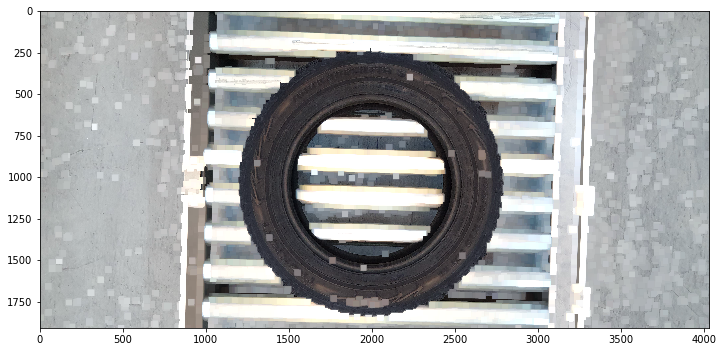

In [10]:
#imgar_bgr = cv2.cvtColor(image_copy_orin_gray, cv2.COLOR_GRAY2BGR)
display_text_img(image_copy_orin)

# watershed algorithm

In [11]:
image_copy_dup = image_copy_orin.copy()
HSV_img_1 = cv2.cvtColor(image_copy_dup, cv2.COLOR_BGR2HSV)
HSV_img_1[:,:,2]  = cv2.equalizeHist(HSV_img_1[:,:,2])   # grabbing the value channel and equalize the histogram. and replace it back
HSV_img_1_eqhist = cv2.cvtColor(HSV_img_1, cv2.COLOR_HSV2BGR) # converting the back to RGB

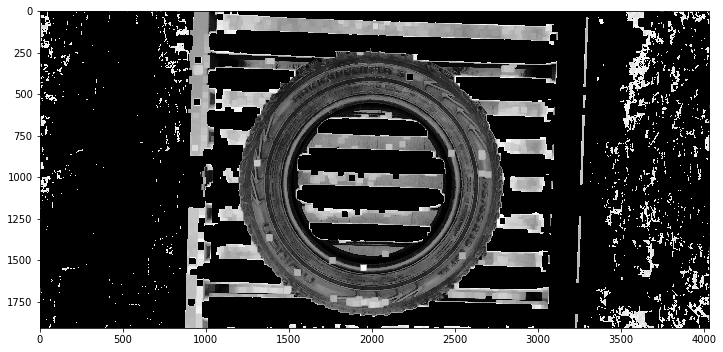

In [12]:
img_blur_watershed = cv2.medianBlur(HSV_img_1_eqhist,5)
img_grayscale_watershed = cv2.cvtColor(img_blur_watershed,cv2.COLOR_BGR2GRAY)
rep_img_watershed, img_binary_threshold_otsu_watershed = cv2.threshold(img_grayscale_watershed,90,255, cv2.THRESH_BINARY_INV+cv2.THRESH_TOZERO)
#adaptiveThreshold_gas = cv2.adaptiveThreshold(img_grayscale_watershed,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,55,13)
display_text_img(img_binary_threshold_otsu_watershed)

In [13]:
kernel_watershed = np.ones((7,7),np.uint8)
opening_watershed = cv2.morphologyEx(img_binary_threshold_otsu_watershed,cv2.MORPH_GRADIENT,kernel_watershed,3)

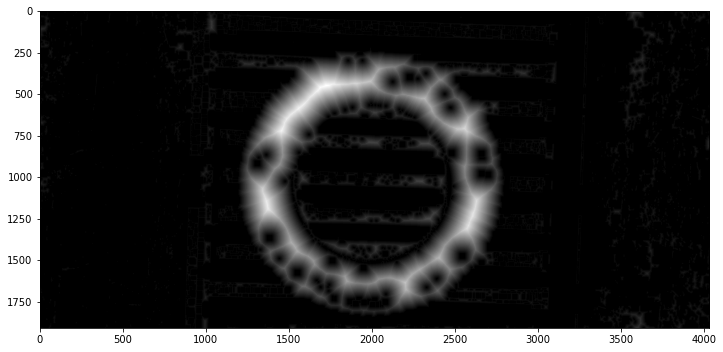

In [14]:
distance_transform = cv2.distanceTransform(opening_watershed, cv2.DIST_L2,5)
display_text_img(distance_transform)

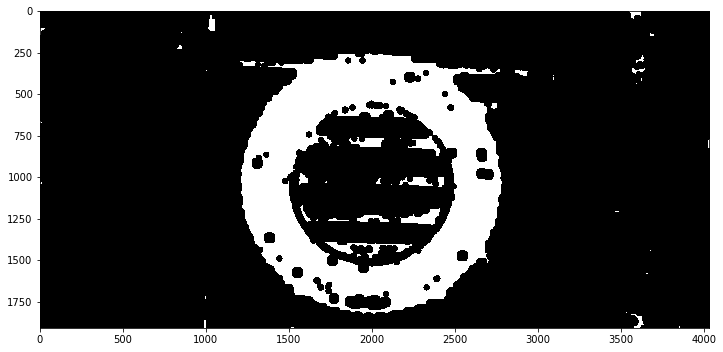

In [15]:
ret_fore, sure_fg = cv2.threshold(distance_transform,0.1101*distance_transform.max(), 255,0)
display_text_img(sure_fg)

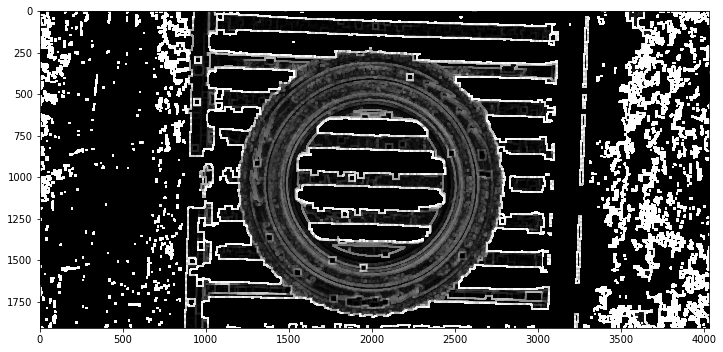

In [16]:
sure_bg = cv2.dilate(opening_watershed,kernel_watershed,3)
display_text_img(sure_bg)

In [17]:
# so convert the sure_fg to uint8
sure_fg = np.uint8(sure_fg)
# to find unknow region 
unknown = cv2.subtract(sure_bg,sure_fg)
# to indentify labelling marker 6 fg and seed for the watershed alogrithm find the segments
ret_mark, markers = cv2.connectedComponents(sure_fg)

In [18]:
HSV_img_1_eqhist_copy = tire_img_1_BGR.copy()
external_coutours = np.zeros(HSV_img_1_eqhist_copy.shape)
external_coutours.shape

(1908, 4032, 3)

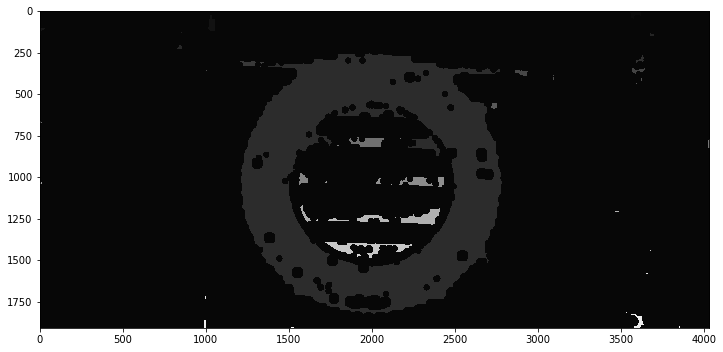

In [19]:
markers = markers + 1
markers[unknown==255] = 0
markers_watershed = cv2.watershed(HSV_img_1_eqhist_copy,markers)
display_text_img(markers_watershed)

In [20]:
image_sep_wat, sep_find_coutour_wat, hierarchy_sep_wat = cv2.findContours(markers_watershed.copy(), cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

In [21]:
def get_contour_center(contour):
    M = cv2.moments(contour)
    cx=-1
    cy=-1
    if (M['m00']!=0):
        cx= int(M['m10']/M['m00'])
        cy= int(M['m01']/M['m00'])
    return cx, cy

In [22]:
for i in range(len(sep_find_coutour_wat)):
#external coutours
    if hierarchy_sep_wat[0][i][3] == -1:
        #cv2.drawContours(img_1_BGR_copy,sep_find_coutour_wat,i,255,10) 
        area = cv2.contourArea(sep_find_coutour_wat[i])
        perimeter= cv2.arcLength(sep_find_coutour_wat[i], True)
        ((x, y), radius) = cv2.minEnclosingCircle(sep_find_coutour_wat[i])
        if radius > 550 and radius <= 1200:
            cv2.drawContours(HSV_img_1_eqhist_copy,sep_find_coutour_wat,i,255,10) 
            cx, cy = get_contour_center(sep_find_coutour_wat[i])
            cv2.circle(external_coutours, (cx,cy),(int)(radius),(0,255,255),10)
            cv2.circle(tire_img_1_BGR, (cx,cy),(int)(radius),(0,255,255),10)
            print ("radius: {}, Area: {}, Perimeter: {}".format(radius, area, perimeter))




radius: 924.1869506835938, Area: 1941008.0, Perimeter: 7007.986385822296


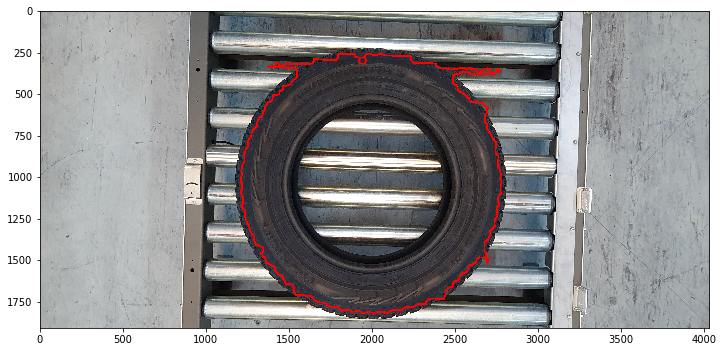

In [23]:
display_text_img(HSV_img_1_eqhist_copy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


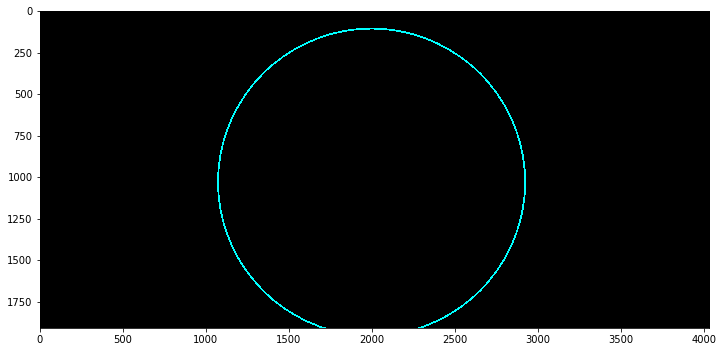

In [24]:
display_text_img(external_coutours)

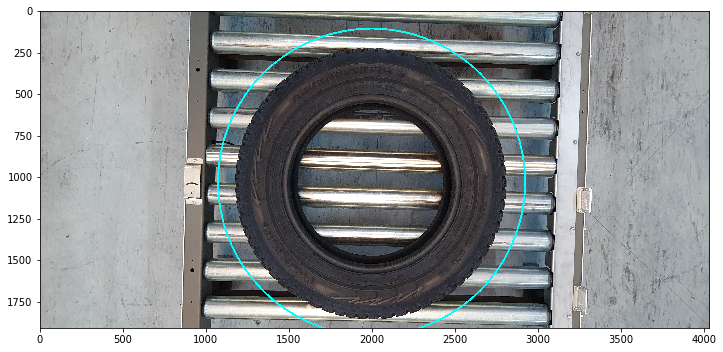

In [25]:
display_text_img(tire_img_1_BGR)